# Customer churn analysis


# Machine Learning Pipeline

In the following notebooks, we will go through the implementation of each one of the steps in the Machine Learning Pipeline. 

We will discuss:

1. Data Preparation and Analysis
2. **Feature Engineering**
3. **Feature Selection**
4. **Model Training**
5. **Obtaining Predictions / Scoring**

In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from snowflake.snowpark.functions import udf
%matplotlib inline
import datetime as dt
import numpy as np
import seaborn as sns

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to save the trained scaler class
import joblib

In [2]:
#Snowflake connection info
from config import snowflake_conn_prop
from snowflake.snowpark import version
print(version.VERSION)

session = Session.builder.configs(snowflake_conn_prop).create()
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

(0, 11, 0)
[Row(CURRENT_WAREHOUSE()='WH_UWM', CURRENT_DATABASE()='UWM_HOUSEHOLDING', CURRENT_SCHEMA()='TEAM1_XURAN')]


In [3]:
%%time
raw = session.sql("select * from TABLE_FOR_TRAINING").collect()
data = pd.DataFrame(raw, columns = ['P1_FIRSTNAME', 'P1_MIDDLENAME', 'P1_LASTNAME',  'P1_ADDRESS_LINE_1', 'P1_ADDRESS_LINE_2', 'P1_ADDRESS_LINE_3', 'P1_CITY', 'P1_STATE', 'P1_ZIP','P2_FIRSTNAME', 'P2_MIDDLENAME', 'P2_LASTNAME', 'P2_ADDRESS_LINE_1', 'P2_ADDRESS_LINE_2', 'P2_ADDRESS_LINE_3', 'P2_CITY', 'P2_STATE', 'P2_ZIP','IFFAMILY', 'P1_CONTACT_ID', 'P2_CONTACT_ID', 'P1_HOUSEHOLD_ID', 'P2_HOUSEHOLD_ID' ])
#data = raw.toPandas()
data

CPU times: total: 266 ms
Wall time: 1.18 s


,P1_FIRSTNAME,P1_MIDDLENAME,P1_LASTNAME,P1_ADDRESS_LINE_1,P1_ADDRESS_LINE_2,P1_ADDRESS_LINE_3,P1_CITY,P1_STATE,P1_ZIP,P2_FIRSTNAME,...,P2_ADDRESS_LINE_2,P2_ADDRESS_LINE_3,P2_CITY,P2_STATE,P2_ZIP,IFFAMILY,P1_CONTACT_ID,P2_CONTACT_ID,P1_HOUSEHOLD_ID,P2_HOUSEHOLD_ID
0,Claire,None,Walls,1031189 Metus St,None,Eugene MD 22207,Eugene,MD,22207,Claire,...,None,Eugene MD 22207,Eugene,MD,22207,0,1,1,99900001,99900001
1,Gemma,None,Ramirez,1539541 Aenean Rd,None,Vancouver HI 26858,Vancouver,HI,26858,Burton,...,None,Vancouver HI 26858,Vancouver,HI,26858,0,27,26,11100002,11100002
2,Lee,None,Silva,2433648 Ante St,None,Grand Island CO 47088,Grand Island,CO,47088,Joy,...,None,Grand Island CO 47088,Grand Island,CO,47088,0,68,69,11100003,11100003
3,Joy,None,Silva,2433648 Ante St,None,Grand Island CO 47088,Grand Island,CO,47088,Mason,...,None,Grand Island CO 47088,Grand Island,CO,47088,0,69,70,11100003,11100003
4,Mason,None,Silva,2433648 Ante St,None,Grand Island CO 47088,Grand Island,CO,47088,Elmo,...,None,Grand Island CO 47088,Grand Island,CO,47088,0,70,71,11100003,11100003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,Rana,None,Meyers,1234 Eget Rd,None,Oklahoma City WA 62624,Oklahoma City,WA,62624,Chastity,...,None,Fort Smith AL 48601,Fort Smith,AL,48601,1,866,865,99900865,99900866
1998,Marcia,None,Vinson,155 Feugiat Rd,None,Hilo NV 86954,Hilo,NV,86954,Zachery,...,None,Chattanooga NE 53323,Chattanooga,NE,53323,1,922,921,99900921,99900922
1999,Dante,None,Jones,8596 Sit Av,None,Oklahoma City MI 81525,Oklahoma City,MI,81525,Cassidy,...,None,South Portland CO 47327,South Portland,CO,47327,1,938,937,99900937,99900938
2000,Stacy,None,Mathis,9400 Ipsum Rd,None,Little Rock AR 97296,Little Rock,AR,97296,Jameson,...,None,Cambridge CA 57118,Cambridge,CA,57118,1,978,979,99900979,99900978


In [4]:
data.shape

(2002, 23)

In [5]:
def encode(s: str):
        if "None" in s:
            s = s.replace("None", " ")
        elif re.search(r'Ave[.]*$', s):
            s = s.replace("Ave", "Avenue")
        elif re.search(r'Av[.]*$', s):
            s = s.replace("Av", "Avenue")
        elif re.search(r'St[.]*$', s):
            s = s.replace("St", "Street")
        elif re.search(r'Rd[.]*$', s):
            s = s.replace("Rd", "Road")
        elif re.search(r'Dr[.]*$', s):
            s = s.replace('Dr', "Drive")
        return s

In [6]:
data["P1_ADDRESS_LINE_1"]= data.apply(lambda row : encode(str(row["P1_ADDRESS_LINE_1"])), axis = 1).map(str)
data["P1_ADDRESS_LINE_2"]= data.apply(lambda row : encode(str(row["P1_ADDRESS_LINE_2"])), axis = 1).map(str)
data["P1_ADDRESS_LINE_3"]= data.apply(lambda row : encode(str(row["P1_ADDRESS_LINE_3"])), axis = 1).map(str)
data["P2_ADDRESS_LINE_1"]= data.apply(lambda row : encode(str(row["P2_ADDRESS_LINE_1"])), axis = 1).map(str)
data["P2_ADDRESS_LINE_2"]= data.apply(lambda row : encode(str(row["P2_ADDRESS_LINE_2"])), axis = 1).map(str)
data["P2_ADDRESS_LINE_3"]= data.apply(lambda row : encode(str(row["P2_ADDRESS_LINE_3"])), axis = 1).map(str)

# Separate dataset into train and test

It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

In [7]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

# to divide train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['P1_CONTACT_ID','P2_CONTACT_ID',
                       'P1_HOUSEHOLD_ID','P2_HOUSEHOLD_ID','IFFAMILY',
                       'P1_FIRSTNAME', 'P1_MIDDLENAME','P2_FIRSTNAME', 'P2_MIDDLENAME',
                       'P1_ADDRESS_LINE_2', 'P2_ADDRESS_LINE_2','P1_LASTNAME',  'P2_LASTNAME'], axis=13), # predictive variables
    data['IFFAMILY'], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape,y_train.shape, y_test.shape

((1601, 10), (401, 10), (1601,), (401,))

## let's identify the different variables

In [8]:
# Since we already cleaned up the data using snowpark, identifying variable is super easy

# we will capture those of type *object*

cat_vars = [ 'P1_ADDRESS_LINE_1', 'P1_ADDRESS_LINE_3','P2_ADDRESS_LINE_1',  'P2_ADDRESS_LINE_3', 
           'P1_CITY', 'P1_STATE','P1_ZIP','P2_CITY', 'P2_STATE','P2_ZIP']

# we will capture those of type numerical from previous notebook
num_vars = [ ]

features = cat_vars + num_vars
print(features)

['P1_ADDRESS_LINE_1', 'P1_ADDRESS_LINE_3', 'P2_ADDRESS_LINE_1', 'P2_ADDRESS_LINE_3', 'P1_CITY', 'P1_STATE', 'P1_ZIP', 'P2_CITY', 'P2_STATE', 'P2_ZIP']


## Numerical variable transformation

In the previous notebook, we observed that the numerical variables are not normally distributed.

We will transform with the MinMaxScaler in order to get a more Gaussian-like distribution. Use ordinal encoding for the categorical variables and check for nulls


In [9]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

In [10]:
# setup pipeline

#transformations
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

#Classifier
from sklearn.ensemble import RandomForestClassifier

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

#Model Accuracy
from sklearn.metrics import balanced_accuracy_score

# Model Pipeline
ord_pipe = make_pipeline(
    FunctionTransformer(lambda x: x.astype(str)) ,
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    )

num_pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0),
    MinMaxScaler()
    )

clf = make_pipeline(RandomForestClassifier(random_state=0, n_jobs=-1))

model = make_pipeline(ord_pipe, num_pipe, clf)

# fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function <lambda> at 0x000001D38E5DA280>)),
                                 ('ordinalencoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1))])),
                ('pipeline-2',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant')),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('pipeline-3',
                 Pipeline(steps=[('randomforestclassifier',
                                  RandomForestClassifier(n_jobs=-1,
                                                         random_state=0))]))])

## Check Accuracy of our model on test dataset

In [11]:
y_pred = model.predict_proba(X_test)[:,1]
predictions = [str(round(value))for value in y_pred]
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print("Model testing completed.\n   - Model Balanced Accuracy: %.2f%%" % (balanced_accuracy * 100.0))

Model testing completed.
   - Model Balanced Accuracy: 100.00%


## Confusion Matrix

In [12]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  383
False Positive(FP) =  0
True Negative(TN)  =  18
False Negative(FN) =  0
Accuracy of the classification = 1.000


## Check for important features

Text(0.5, 0, 'Feature Importance')

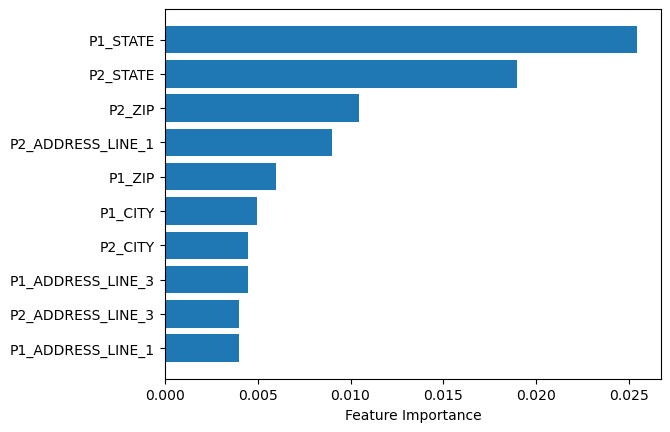

In [13]:
# Feature importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(np.array(X_test.columns)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature Importance")

In [14]:
session.close()